In [140]:
import json
import numpy as np
import networkx as nx
from scipy.optimize import minimize
from plotter_lib import *

### Definimos la función error para el optimizador

In [141]:
def get_metricas(links, w):

    G = nx.DiGraph()

    for i in range(len(links)):

        n1, n2 = links[i].split(' ')
        G.add_edge(n1, n2, weight=w[i])

    ec = nx.eigenvector_centrality(G, weight="weight")
    bc = nx.betweenness_centrality(G, weight="weight")
    c = nx.clustering(G, weight="weight")

    return [ec, bc, c]

alpha = 1.0
beta  = 1.07
gamma = 3.3

def fobj(pars, args):

    links, players, mu = args

    Ec, Bc, C = get_metricas(links, np.array(pars, dtype=int))

    metr= "bc"

    return sum([alpha*(Ec[player] -mu["ec"][player])**2 + 
               beta*(Bc[player] - mu["bc"][player])**2 +
               gamma*(C[player] - mu["c"][player])**2 for player in players])


### Preparo los argumentos

In [142]:
# jugadores titulares
#players = ['Player1', 'Player2', 'Player3', 'Player4', 'Player5', 'Player6', 'Player7', 'Player8', 'Player9', 'Player10']
players = [ 'Player1', 'Player2', 'Player3', 'Player4', 'Player5', 'Player6', 'Player7', 'Player8', 'Player9']

arxs = "edgelists/red_optima_3_p10.edgelist"

# todos los posibles links
n = len(players)
links = [ ]

for i in range(n):
    for j in range(n):
        if i!=j:
            links.append( "%s %s"%(players[i],players[j]) )



#elejimos metricas
arx = '../player_metrica_S1.json'
d = json.load(open(arx, "r"))

mu={}
mu["ec"]={  player:np.mean(d[player]["ec"]) for player in players }
mu["bc"]={  player:np.mean(d[player]["bc"]) for player in players }
mu["c"]={  player:np.mean(d[player]["c"]) for player in players }




args = [ links,players,mu  ]


### Optimizo

In [143]:

pars0 = np.ones(len(links))
bounds = [ (0, 10) for i in range(len(links)) ]

res = minimize(fobj, pars0, args=args, method="Powell", bounds=bounds)

res



 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 0.08011989791130719
       x: [ 7.302e+00  2.075e+00 ...  1.219e+00  1.138e+00]
     nit: 3
   direc: [[ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]
           [ 0.000e+00  1.000e+00 ...  0.000e+00  0.000e+00]
           ...
           [ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]
           [-3.610e-02 -8.024e-04 ... -2.661e-03 -3.073e-03]]
    nfev: 4823

### Chequeo que el resultado sea correcto

In [144]:
pesos = res.x.astype(int)

In [145]:
Ec,Bc,C = get_metricas(links, res.x)

sd={}
sd["ec"]={  player:np.std(d[player]["ec"]) for player in players }
sd["bc"]={  player:np.std(d[player]["bc"]) for player in players }
sd["c"]={  player:np.std(d[player]["c"]) for player in players }
count_no=0

print ("Eigenvector Centrality")
for player in players:

    l1,l2 = mu["ec"][player]-sd["ec"][player], mu["ec"][player]+sd["ec"][player]
    
    if Ec[player]>l2 or Ec[player]<l1:
        count_no+=1
        print ( player, l1, "| %f |" %Ec[player] , l2, "  X")
    else:
        print ( player, l1, "| %f |" %Ec[player] , l2)


print ("\nBetweenness")
for player in players:

    l1,l2 = mu["bc"][player]-sd["bc"][player], mu["bc"][player]+sd["bc"][player]
    
    if Bc[player]>l2 or Bc[player]<l1:
        count_no+=1
        print ( player, l1, "| %f |" %Bc[player] , l2, "  X")
    else:
         print ( player, l1, "| %f |" %Bc[player] , l2)


print ("\nClustering")
for player in players:

    l1,l2 = mu["c"][player]-sd["c"][player], mu["c"][player]+sd["c"][player]
    
    if C[player]>l2 or C[player]<l1:
        count_no+=1
        print ( player, l1, "| %f |" %C[player] , l2, "  X")
    else:
         print ( player, l1, "| %f |" %C[player] , l2)


print ("\nNro casos fuera:", count_no)

Eigenvector Centrality
Player1 0.1808256798117162 | 0.259069 | 0.3026705423892874
Player2 0.0684152819837958 | 0.245270 | 0.27707424461725105
Player3 0.04514041289076494 | 0.219763 | 0.2264852319550637
Player4 0.2812174258093085 | 0.436677 | 0.5469438080445308
Player5 0.3126430869251662 | 0.408305 | 0.45285535628454887
Player6 0.2769308847557014 | 0.363801 | 0.4234938191200025
Player7 0.08542764399209277 | 0.312691 | 0.4388688297596225
Player8 0.22050169323507524 | 0.350848 | 0.4067762901777438
Player9 0.19787303019639885 | 0.337357 | 0.5000898047425932

Betweenness
Player1 0.01454635896931493 | 0.035714 | 0.21775282332986734
Player2 0.007395805077633752 | 0.017857 | 0.07575955807772941
Player3 0.0008091187302524359 | 0.071429 | 0.04938328146214775   X
Player4 0.05595584432276325 | 0.125000 | 0.2839723491768588
Player5 0.037227773180369766 | 0.053571 | 0.288558662606066
Player6 0.0656058649662493 | 0.089286 | 0.21128807442769004
Player7 0.029989530832165295 | 0.053571 | 0.1752293243866

In [146]:
edgelist= [ "%s %d" % (links[i],pesos[i]) for i in range(len(links)) if pesos[i]>0 ]

np.savetxt(arxs, edgelist, fmt="%s")



In [147]:
#players = ['Player1', 'Player2', 'Player3', 'Player4', 'Player5', 'Player6', 'Player7', 'Player8', 'Player9', 'Player10']

#colorDict = {    player:"C%d"%i for i,player in enumerate(players)}

#json.dump(colorDict, open("colorDict.json","w") )

(-0.05, 0.6)

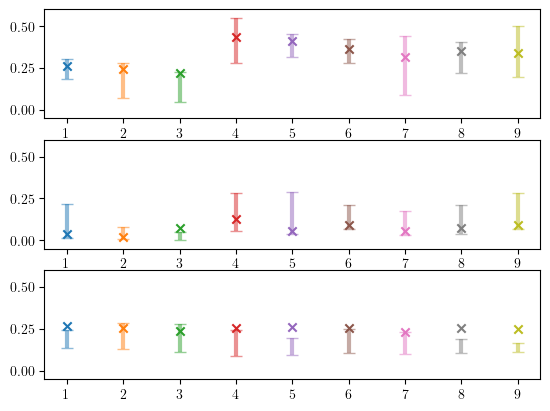

In [148]:
fig,ax = plt.subplots(3,1)

i=1
for player in players:

    ax[0].errorbar( i, mu["ec"][player], sd["ec"][player],alpha=0.5 ,elinewidth=3,capsize=4)
    ax[0].scatter( [i],[Ec[player]], marker='x' )

    ax[1].errorbar( i, mu["bc"][player], sd["bc"][player],alpha=0.5 ,elinewidth=3,capsize=4)
    ax[1].scatter( [i],[Bc[player]], marker='x' )

    ax[2].errorbar( i, mu["c"][player], sd["c"][player],alpha=0.5 ,elinewidth=3,capsize=4)
    ax[2].scatter( [i],[C[player]], marker='x' )


    i+=1

ax[0].set_ylim(-0.05,0.6)
ax[1].set_ylim(-0.05,0.6)
ax[2].set_ylim(-0.05,0.6)